# Serie elegida, Precios promedios del combustible Superior en Guatemala de 2021-2025

Previamente se realizó una serie de tiempo para el precio diario de la gasolina en Guatemala. La idea es mejorar el modelo realizado pero ahora usando LSTM. Se ralizaran 2 modelos para esta serie previamente analizada. Los datos son exactamente los mismos y la idea es comparar el desempeño de la serie anterior con el LTS nuevo. La primera parte del análisis es la misma que en la práctica anterior, ver la estacionalidad, diferenciaciones etc.



In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

#Tensorflow
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential,save_model,load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.metrics import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
import keras
import seaborn as sns

In [29]:
import pandas as pd

# funcion para procesar los libros de excel
def load_year_data(year, table_header_start, last_row):
    df = pd.read_excel('Datos_precios/Precios-Promedio-Nacionales-Diarios-2025-1.xlsx',
                       sheet_name=str(year),
                       header= table_header_start,
                       usecols=['FECHA', 'Superior'])
    
    # todos los archivos tienen una linea extra entre el encabezado y los datos
    df = df.iloc[1:last_row]
    
    # Convertir fecha y asegurar formato correcto
    df['FECHA'] = pd.to_datetime(df['FECHA'])
    df['Superior'] = pd.to_numeric(df['Superior'], errors='coerce')
    
    return df

df_2021 = load_year_data("2021", 6, 366)
df_2022 = load_year_data("2022", 6, 366)
df_2023 = load_year_data("2023", 7, 366)
df_2024 = load_year_data("2024", 7, 367)
df_2025 = load_year_data("2025", 7, 195)


## Ahora que ya se tienen los datos de los años de 2021 a 2025. Es necesario juntarlos

In [30]:
# Combinar todos los DataFrames en uno solo
df_completo = pd.concat([df_2021, df_2022, df_2023, df_2024, df_2025], ignore_index=True)

# Ordenar por fecha
df_completo = df_completo.sort_values('FECHA').reset_index(drop=True)

# Ver resultado
print("Primeras filas:")
print(df_completo.head())
print("\nÚltimas filas:")
print(df_completo.tail())
print(f"\nRango de fechas: {df_completo['FECHA'].min()} a {df_completo['FECHA'].max()}")
print(f"Total de registros: {len(df_completo)}")

Primeras filas:
       FECHA  Superior
0 2021-01-01     21.91
1 2021-01-02     21.91
2 2021-01-03     21.91
3 2021-01-04     21.91
4 2021-01-05     21.91

Últimas filas:
          FECHA  Superior
1650 2025-07-09     30.98
1651 2025-07-10     30.98
1652 2025-07-11     30.98
1653 2025-07-12     30.98
1654 2025-07-13     30.98

Rango de fechas: 2021-01-01 00:00:00 a 2025-07-13 00:00:00
Total de registros: 1655


# Analisis exploratorio del set completo

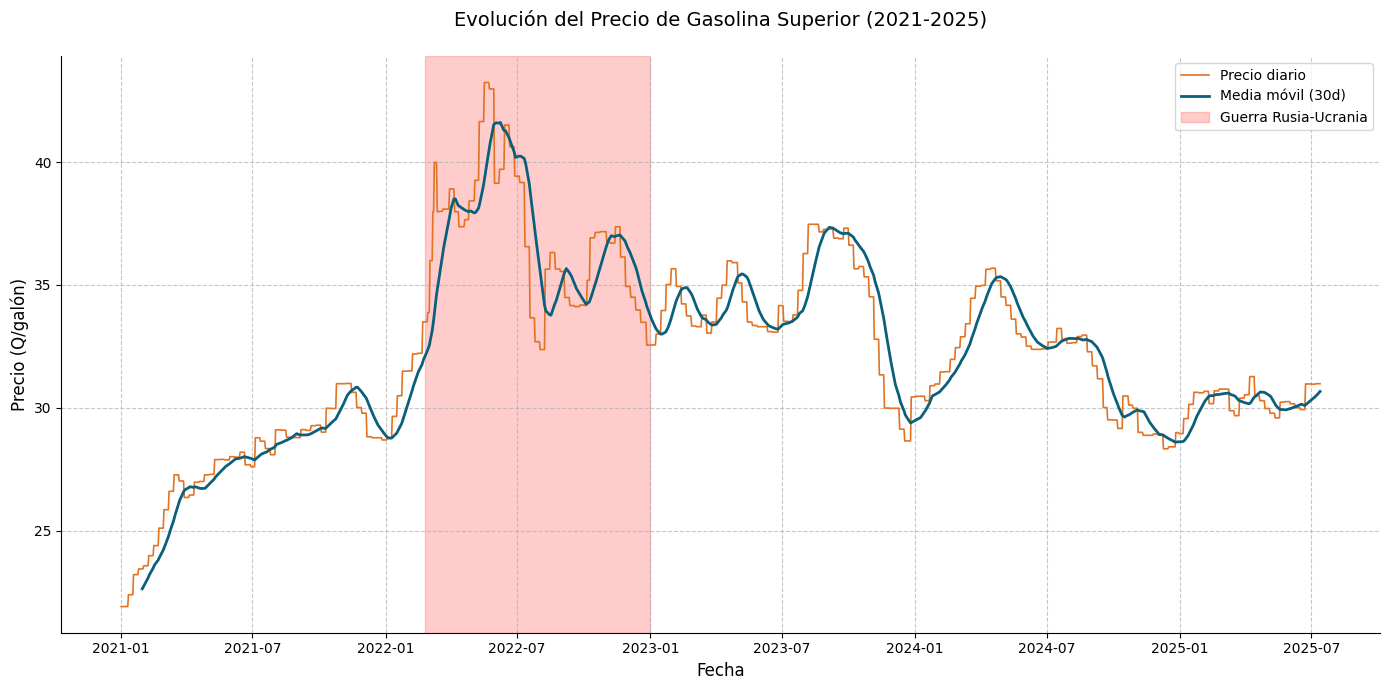

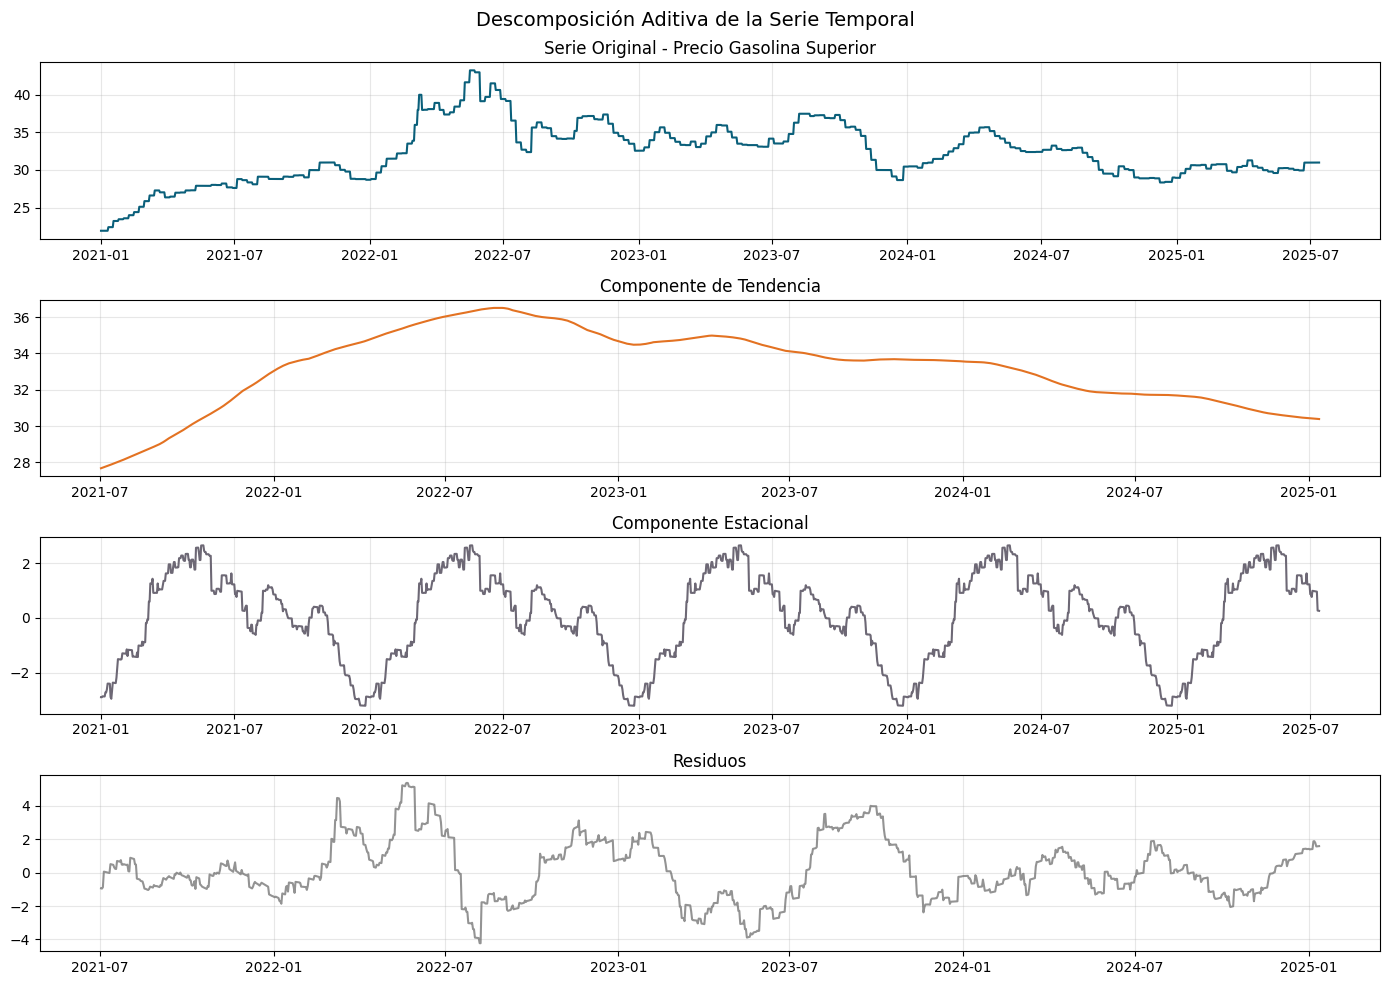

In [31]:
plt.figure(figsize=(14, 7))

# Opción 1: Línea simple
plt.plot(df_completo['FECHA'], df_completo['Superior'], 
         color='#E37222', linewidth=1.2, label='Precio diario')

# Opción 2: Promedio móvil (suaviza la serie)
window_size = 30  # Promedio de 30 días
plt.plot(df_completo['FECHA'], df_completo['Superior'].rolling(window_size).mean(), 
         color='#0A5F7A', linewidth=2, label=f'Media móvil ({window_size}d)')

# Destacar eventos importantes
plt.axvspan(pd.to_datetime('2022-02-24'), pd.to_datetime('2022-12-31'), 
            alpha=0.2, color='red', label='Guerra Rusia-Ucrania')

plt.title('Evolución del Precio de Gasolina Superior (2021-2025)\n', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Precio (Q/galón)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
sns.despine()
plt.tight_layout()
plt.show()



# Configurar la serie temporal (asegurando frecuencia diaria)
ts = df_completo.set_index('FECHA')['Superior'].asfreq('D').interpolate()

# Descomposición aditiva (modelo alternativo: multiplicative)
result = seasonal_decompose(ts, model='additive', period=365)

# Visualización mejorada
plt.figure(figsize=(14, 10))

# Serie Original
plt.subplot(4, 1, 1)
plt.plot(result.observed, color='#0A5F7A')
plt.title('Serie Original - Precio Gasolina Superior', fontsize=12)
plt.grid(alpha=0.3)

# Tendencia
plt.subplot(4, 1, 2)
plt.plot(result.trend, color='#E37222')
plt.title('Componente de Tendencia', fontsize=12)
plt.grid(alpha=0.3)

# Estacionalidad
plt.subplot(4, 1, 3)
plt.plot(result.seasonal, color='#6D6875')
plt.title('Componente Estacional', fontsize=12)
plt.grid(alpha=0.3)

# Residuos
plt.subplot(4, 1, 4)
plt.plot(result.resid, color='#666666', alpha=0.7)
plt.title('Residuos', fontsize=12)
plt.grid(alpha=0.3)

plt.suptitle('Descomposición Aditiva de la Serie Temporal', fontsize=14)
plt.tight_layout()
plt.show()

# Análisis de estacionalidad

Se ve claramente que hay estacionalidad en el set de datos. La estacionalidad es de aproximadamente 1 año. La forma de la gráfica se repite cada año/cada 12 meses. 


# Analisis de estacionariedad

Previamente se demostró que aunque la serie parece no ser estacionaria, la prueba de Dickey FUller Aumentada muestra que no es necesario diferenciar.

Diferenciación d=0: p-value = 0.0267 → Estacionari

Número óptimo de diferenciaciones (d): 0
Prueba de Dickey-Fuller Aumentada: Serie Original
ADF Statistic             -3.097852
p-value                    0.026713
#Lags                      7.000000
#Observations           1647.000000
Critical Value (1%)       -3.434327
Critical Value (5%)       -2.863296
Critical Value (10%)      -2.567705
--------------------------------------------------
Rechazamos la hipótesis nula
La serie ES estacionaria


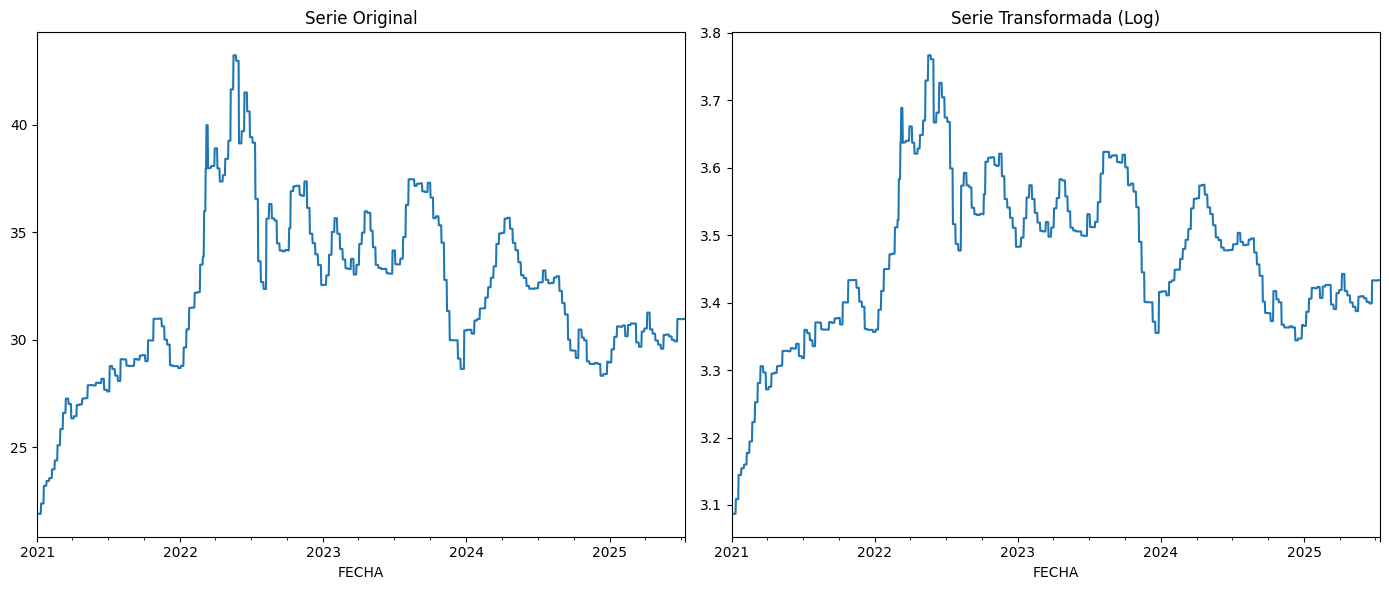

Prueba de Dickey-Fuller Aumentada: Serie Logarítmica
ADF Statistic             -3.351009
p-value                    0.012747
#Lags                      7.000000
#Observations           1647.000000
Critical Value (1%)       -3.434327
Critical Value (5%)       -2.863296
Critical Value (10%)      -2.567705
--------------------------------------------------
Rechazamos la hipótesis nula
La serie ES estacionaria
Diferenciación d=0: p-value = 0.0127 → Estacionari

Número óptimo de diferenciaciones (d): 0


In [32]:


def test_adfuller(series, title=''):
    print(f'Prueba de Dickey-Fuller Aumentada: {title}')
    result = adfuller(series.dropna(), autolag='AIC')  # AIC para selección automática de lags
    
    labels = ['ADF Statistic', 'p-value', '#Lags', '#Observations']
    out = pd.Series(result[0:4], index=labels)
    
    for key, val in result[4].items():
        out[f'Critical Value ({key})'] = val
    
    print(out.to_string())
    print('-'*50)
    
    if result[1] <= 0.05:
        print("Rechazamos la hipótesis nula")
        print("La serie ES estacionaria")
    else:
        print("No podemos rechazar la hipótesis nula")
        print("La serie NO ES estacionaria")

from statsmodels.tsa.stattools import adfuller

def find_optimal_d(series, max_diff=2):
    for d in range(max_diff + 1):
        if d == 0:
            diff_series = series
        else:
            diff_series = series.diff(d).dropna()
        
        result = adfuller(diff_series)
        p_value = result[1]
        
        print(f'Diferenciación d={d}: p-value = {p_value:.4f}', end=' ')
        if p_value <= 0.05:
            print('→ Estacionari')
            return d
        else:
            print('→ No estacionaria')
    
    print("No se alcanzó estacionariedad con las diferenciaciones probadas")
    return None

optimal_d = find_optimal_d(ts)
print(f'\nNúmero óptimo de diferenciaciones (d): {optimal_d}')

test_adfuller(ts, 'Serie Original')
ts_log = np.log(ts)

# Visualización comparativa
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
ts.plot(title='Serie Original')
plt.subplot(1, 2, 2)
ts_log.plot(title='Serie Transformada (Log)')
plt.tight_layout()
plt.show()

# Repetir prueba ADF
test_adfuller(ts_log, 'Serie Logarítmica')

optimal_d_log = find_optimal_d(ts_log)
print(f'\nNúmero óptimo de diferenciaciones (d): {optimal_d_log}')

Realmente parece no haber mucha diferencia con la serie original a primera vista y por la prueba de Dickey-Fuller Aumentada podemos ver que en efecto la seria es estacionaria incluso antes de la transformación. Las diferenciaciones óptimas son 0 (d = 0) para el arima. Con esto podemos concluir que aunque visualmente no es estacionaria la serie, realmente la desviaciones en media y varianza resultan no ser tan significativas. Ya que incluso luego de la transformación la gráfica parece no cambiar mucho. 

Sabiendo que no es necesario diferenciar la serie, entonces se puede proceder con la transformación de los datos para ser usados por una red neuronal. Usaremos el set de datos "ts", el que no esta transformado, ni diferenciado, ya que pasó la prueba del p-value.

In [37]:

ts


FECHA
2021-01-01    21.91
2021-01-02    21.91
2021-01-03    21.91
2021-01-04    21.91
2021-01-05    21.91
              ...  
2025-07-09    30.98
2025-07-10    30.98
2025-07-11    30.98
2025-07-12    30.98
2025-07-13    30.98
Freq: D, Name: Superior, Length: 1655, dtype: float64

In [39]:
scaler = StandardScaler()
ts_reset = ts.reset_index()  # Convierte 'FECHA' de nuevo en columna
ts_reset['Superior_scaled'] = scaler.fit_transform(ts_reset[['Superior']])

ts_reset = ts_reset.set_index('FECHA')
print(ts_reset.head())

            Superior  Superior_scaled
FECHA                                
2021-01-01     21.91        -2.683439
2021-01-02     21.91        -2.683439
2021-01-03     21.91        -2.683439
2021-01-04     21.91        -2.683439
2021-01-05     21.91        -2.683439


# Separación de los datos
Al igual que en el caso de la predicción con los modelos ARIMA y SARIMAX, se tomaran 3 años previos (2022-2024) como entrenamiento y test como la información que se tiene hasta el momento de 2025. Aunque con la ligera diferencia que ahora tambien es necesario tener en cuenta el validation y no solo test.

In [40]:
train = ts_reset['2022-01-01':'2023-12-31']
validation = ts_reset['2024-01-01':'2024-12-31']
test = ts_reset['2025-01-01':]

print(f"Train: {train.shape[0]} puntos ({train.index.min()} a {train.index.max()})")
print(f"Validation: {validation.shape[0]} puntos ({validation.index.min()} a {validation.index.max()})")
print(f"Test: {test.shape[0]} puntos ({test.index.min()} to {test.index.max()})")

Train: 730 puntos (2022-01-01 00:00:00 a 2023-12-31 00:00:00)
Validation: 366 puntos (2024-01-01 00:00:00 a 2024-12-31 00:00:00)
Test: 194 puntos (2025-01-01 00:00:00 to 2025-07-13 00:00:00)


Para que pueda usarse el argoritmo LSTM es necesario transformar la serie en una supervisada, de manera que las observaciones anteriores sean capaces de estimar la siguiente. En este caso vamos a usar el mes anterior para predecir el siguiente por lo que vamos a transformar el arreglo de numpy en una matriz de dos dimensiones en la que la dimensión 1 sea el instante t-1 y la dimensión 2 sea el instante t

In [43]:
import numpy as np

def supervisada(serie, retrasos=1):
    serie_x = []
    serie_y = []
    serie_array = serie.values if isinstance(serie, pd.DataFrame) else serie  # Convierte a array
    for i in range(len(serie_array) - retrasos):
        valor = serie_array[i:(i + retrasos)]
        valor_sig = serie_array[i + retrasos]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

# superior escaled es la columna con el precio del galon escalado
# para que sea procesado mejor por la red neuronal

x_train, y_train = supervisada(train[['Superior_scaled']])  # 5 lags
x_val, y_val = supervisada(validation[['Superior_scaled']])
x_test, y_test = supervisada(test[['Superior_scaled']])

# Verificamos formas
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}") 
print(train[0:6])
print(x_train[0:6])
print(y_train[0:6])


x_train shape: (729, 1, 1)
y_train shape: (729, 1)
            Superior  Superior_scaled
FECHA                                
2022-01-01     28.69        -0.906560
2022-01-02     28.69        -0.906560
2022-01-03     28.79        -0.880352
2022-01-04     28.79        -0.880352
2022-01-05     28.79        -0.880352
2022-01-06     28.79        -0.880352
[[[-0.90655988]]

 [[-0.90655988]]

 [[-0.88035223]]

 [[-0.88035223]]

 [[-0.88035223]]

 [[-0.88035223]]]
[[-0.90655988]
 [-0.88035223]
 [-0.88035223]
 [-0.88035223]
 [-0.88035223]
 [-0.88035223]]



## Creando el modelo
Para que pueda hacerse el modelo se le tiene que suministrar una matriz de 3 dimensiones siendo estas:
- ***Muestras:*** número de observaciones en cada lote, también conocido como tamaño del lote.
- ***Pasos de tiempo:*** Pasos de tiempo separados para una observación dada. En este ejemplo los pasos de tiempo = 1
- ***Características:*** Para un caso univariante, como en este ejemplo, las características = 1  

Un modelo LSTM permite ingresar datos a una red y hacer predicciones basados en pasos individuales de datos secuenciales. Como es una serie de tiempo donde queremos predecir el próximo elemento, usaremos un modelo secuencial, para predecir el próximo elemento, por esto es que el paso es 1.

El número de neuronas en la capa de salida (Dense) debe estar en la forma en que necesitamos la salida, en el caso de las series de tiempo necesitamos una neurona porque queremos predecir un valor. 

Vamos a convertir los conjuntos en matrices de 3 dimensiones __(Texto extraido del ejemplo de clase)__ :

In [44]:
x_train = np.reshape(x_train,(x_train.shape[0],1,1))
x_val = np.reshape(x_val, (x_val.shape[0],1,1))
x_test = np.reshape(x_test, (x_test.shape[0],1,1))
len(x_val)

365

# Creación del primer modelo (1 CAPA) usando tensorflow

In [45]:
lote = 1
unidades =  1
paso = 1
caracteristicas = 1 #es univariada

inputs = keras.layers.Input((paso,caracteristicas))
lstm_out = keras.layers.LSTM(lote)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

modelo1 = keras.Model(inputs=inputs, outputs=outputs)
modelo1.summary()

#Tensor Flow 2
#modelo1 = Sequential()
#modelo1.add(LSTM(lote,batch_input_shape=(lote,paso,caracteristicas),stateful=True))
#modelo1.add(Dense(1))
#modelo1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 1)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14 (56.00 B)

 Trainable params: 14 (56.00 B)

 Non-trainable params: 0 (0.00 B)

Compilamos el modelo. Las métricas que nos van a servir para saber como funciona el modelo en términos de la pérdida es el error medio cuadrado. 
Se le puso una detención temprana para ahorrar tiempo de entrenamiento. Para el entrenamiento del modelo cuando se da cuenta de que no habrá disminución de la pérdida en las siguientes épocas. __(Texto extraido del ejemplo de clase)__

In [47]:
#early_stop = EarlyStopping(monitor='val_loss', patience=1)
modelo1.compile(loss='mean_squared_error',optimizer=Adam(learning_rate=0.1), metrics = [RootMeanSquaredError()])
modelo1

<Functional name=functional, built=True>

In [48]:
epocas = 60
history= modelo1.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    #callbacks=[early_stop],
    verbose=1
)

Epoch 1/60
729/729 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.1298 - root_mean_squared_error: 0.3558 - val_loss: 0.8478 - val_root_mean_squared_error: 0.9208
Epoch 2/60
729/729 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.1070 - root_mean_squared_error: 0.3201 - val_loss: 0.8401 - val_root_mean_squared_error: 0.9166
Epoch 3/60
729/729 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.1052 - root_mean_squared_error: 0.3178 - val_loss: 0.8357 - val_root_mean_squared_error: 0.9142
Epoch 4/60
729/729 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.1045 - root_mean_squared_error: 0.3169 - val_loss: 0.8328 - val_root_mean_squared_error: 0.9126
Epoch 5/60
729/729 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1042 - root_mean_squared_error: 0.3164 - val_loss: 0.8307 - val_root_mean_squared_error: 0.9114
Epoch 6/60
729/729 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1040 - root_mean_squared_error: 0.3162 - val_loss: 0.8290 - val_root_mean_squared_error: 0.9105
Epoch 7/60
729/729 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step 

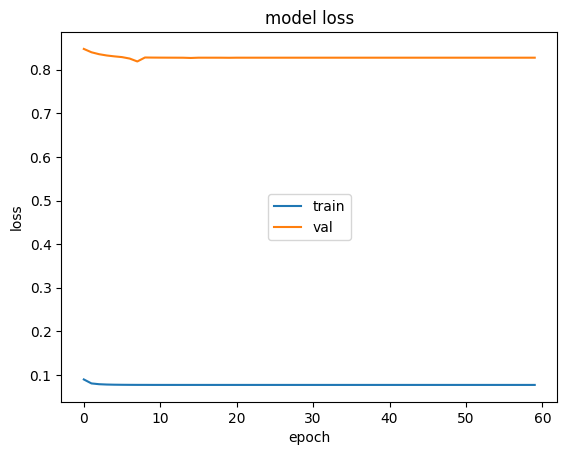

In [49]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

<Axes: >

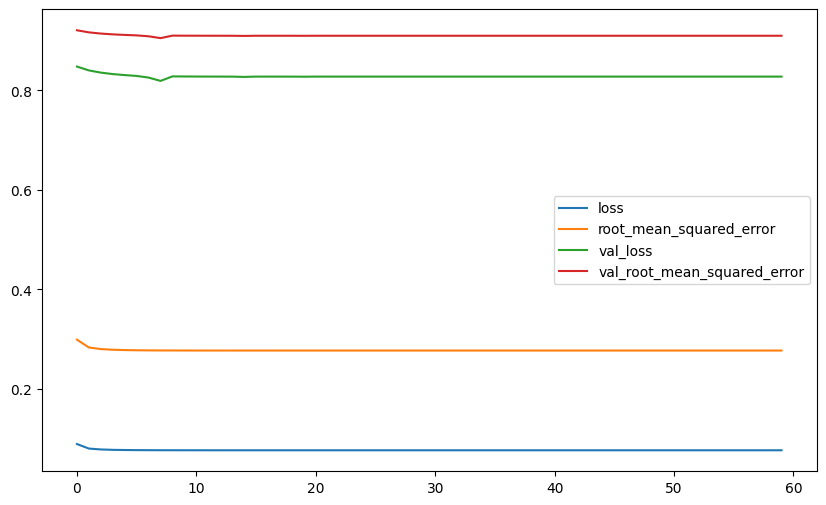

In [50]:
losses_df1 = pd.DataFrame(history.history)

losses_df1.plot(figsize = (10,6))

In [51]:
print("Pérdida en Entrenamiento")
modelo1.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo1.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Prueba")
modelo1.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Entrenamiento
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.5884 - root_mean_squared_error: 1.8500  
Pérdida en Validación
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9459 - root_mean_squared_error: 0.9516 
Pérdida en Prueba
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1407 - root_mean_squared_error: 0.3748


[0.1465519666671753, 0.38282105326652527]